In [153]:
using Petri
using MacroTools
import MacroTools: postwalk, striplines
using ModelingToolkit
import ModelingToolkit: Constant
import Base: ==, ∈, show, ^
using Catlab.Doctrines
import Catlab.Doctrines: ⊗, compose, otimes
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
import Catlab.Graphics.Graphviz: Graph
using SemanticModels
using SemanticModels.ModelTools.WiringDiagrams

In [154]:
using LabelledArrays
using OrdinaryDiffEq
import OrdinaryDiffEq: solve
using Plots
Petri.N(s) = 1 #sum(s[1:end-3])

In [155]:
⊗(f::OpenModel,g::OpenModel) = otimes(f,g)
⊚(f::OpenModel,g::OpenModel) = compose(f,g)

^(x::Doctrines.FreeSymmetricMonoidalCategory.Ob{:generator}, n::Int) = foldl(⊗, x for i in 1:n)
^(f::Doctrines.FreeSymmetricMonoidalCategory.Hom{:id}, n::Int64) = foldl(⊗, f for i in 1:n)

conj(a::OpenModel, b::OpenModel) = compose(b,a,b)
conj(a, b) = compose(b,a,b) 
""" op(f::Model)

return the opposite model you get by reversing the direction of all the transitions
"""
op(f::Model) = Model(f.S, map(f.Δ) do t reverse(t) end)

op(f::OpenModel) = OpenModel(f.dom, op(f.model), f.codom)
wd(ex) = to_wiring_diagram(ex)

function compile(expr::Doctrines.FreeSymmetricMonoidalCategory.Hom{:compose}, ctx::Dict)
#     println("∘")
    compose(compile.(expr.args, (ctx,)))
end
function compile(expr::Doctrines.FreeSymmetricMonoidalCategory.Hom{:otimes}, ctx::Dict)
#     println("⊗")
    otimes(compile.(expr.args, (ctx,)))
end
function compile(expr, ctx::Dict)
    # @show expr
    return ctx[expr]
end


compile (generic function with 4 methods)

In [156]:
function show(io::IO, z::Petri.Model)
    X, Y = z.S, z.Δ
    compact = get(io, :compact, true)
    if compact
        x,y = length(X), length(Y)
        print(io,"Model(∣S∣=$x,∣Δ∣=$y)")
    else
        print(io,"Model(S=$X, Δ=$Y)")
    end
end
function show(io::IO, z::OpenModel)
    X,Y = z.dom, z.codom
    compact = get(io, :compact, true)
    if compact
        x,y = length(X), length(Y)
        print(io,"OpenModel:$x→$y with ")
        show(io,z.model)
    else
        print(io,"Domain: $X\nCodomain: $Y\nModel: ")
        show(io, z.model)
    end
end


function debug_show(io::IO, f::Model)
    X,Y = f.S, f.Δ
    print(io,"Model(S=$X, Δ=")
    if length(Y) == 0
        print("[])")
    else
        for (i,t) in enumerate(Y)
            if i == 1
                print(io, "[")
                print(io, "$(t[1])→$(t[2]),")
            end
            if 1 < i < length(Y)
                print(io, " $(t[1])→$(t[2]),")
            end
            if i == length(Y)
                print(io, " $(t[1])→$(t[2])])\n")
            end
        end
    end
end

debug_show(io::IO, f::OpenModel) = begin
    X,Y = f.dom, f.codom
    print(io,"Domain: $X\nCodomain: $Y\nModel: ")
    debug_show(io, f.model)
    println(io, "\n")
    g = Graph(f)
end
            
debug_show(f::OpenModel) = begin
    debug_show(stdout, f)
end

function debug_show(io::IO, f::OpenModel, fname::String)
    g = debug_show(io, f)
    output = run_graphviz(g, prog="dot", format="svg")
    write(fname, output)
    return g
end

debug_show(f::OpenModel, fname::String) = debug_show(stdout, f, fname)
odeexpr(m::OpenModel) = symbolic_symplify(Petri.odefunc(m.model, :state)) |> striplines

odeexpr (generic function with 1 method)

In [157]:
Base.show(io::IO, mime::MIME"text/html", f::OpenModel) = begin 
    g = debug_show(io, f)
    show(io, mime, g)
    g
end
import Base.display
display(f::OpenModel) = debug_show(f)
display(f::WiringDiagram) = to_graphviz(f, direction=:horizontal)
pad(f::WiringDiagram, v::Vector) = vcat(v, ["" for i in 1:length(wires(f))-length(v)])
display(f::WiringDiagram, labels::Vector) = SemanticModels.ModelTools.WiringDiagrams.label!(display(f), string.(pad(f, labels)))

display (generic function with 34 methods)

In [158]:
Base.Filesystem.mkpath("img")
X = Petri.X;

# Primitives of Petri Net Modeling Framework

We start by defining some primitive models. First is the spontaneous reaction. It takes $X_1\rightarrow X_2$


Spontaneous reaction: spontaneous = X₁→X₂
Domain: [1, 2]
Codomain: [1, 2]
Model: Model(S=[1, 2], Δ=[X₁()→X₂(), X₁()→X₂()])




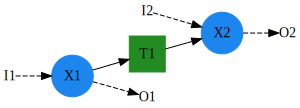

In [159]:
println("\nSpontaneous reaction: spontaneous = X₁→X₂")
spontaneous = OpenModel([1,2], Model([1,2], [(X[1],X[2])]), [1,2])
display(spontaneous)

We can compose models by wiring the inputs of one to the outputs of another. We define most of our primitives to have all variables as inputs and outputs.

Domain: [1, 2]
Codomain: [1, 2]
Model: Model(S=[1, 2], Δ=[X₁()→X₂(), X₁()→X₂()])




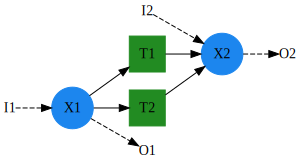

In [160]:
display(compose(spontaneous,spontaneous))

1. TODO: Diagram for teaching how to compose petri nets
2. TODO: label the wires with Variable names
```julia
  label!(g::Grapviz, v::Vector{Symbol})
```
3. TODO: fix SIIR example
4. TODO: don't say SMC
5. Give demo without saying categories

We can also combine models by stacking them one on top of the other independently


Parallel reaction: parallel = spontaneous ⊗ spontaneous = X₁→X₂, X₃→X₄
Domain: [1, 2, 3, 4]
Codomain: [1, 2, 3, 4]
Model: Model(S=[1, 2, 3, 4], Δ=[X₁()→X₂(), X₃()→X₄()])




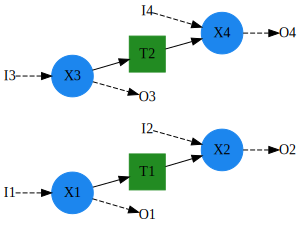

In [161]:
println("\nParallel reaction: parallel = spontaneous ⊗ spontaneous = X₁→X₂, X₃→X₄")
parallel = spontaneous ⊗ spontaneous
display(parallel)

In order to introduce new variables, you can use the `eye(1)` model with represents the identity process on 1 variable. This pattern of $a\otimes I; I \otimes b$ will be very important. We will use the $f;g$ operator to denote composition of $f$ followed by $g$ because the mathematical symbol $f\circ g$ is already defined as $g(f)$ which is backwards. 

Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3], Δ=[X₁()→X₂(), X₂()→X₃()])




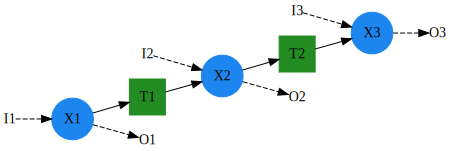

In [162]:
display(compose(spontaneous ⊗ eye(1), eye(1) ⊗ spontaneous))


Infection reaction infect = X₁+X₂→ 2X₂
Domain: [1, 2]
Codomain: [1, 2]
Model: Model(S=[1, 2], Δ=[X₁() + X₂()→2 * X₂(), X₁() + X₂()→2 * X₂()])




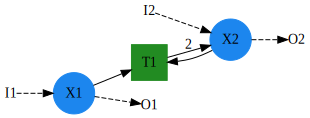

In [163]:
println("\nInfection reaction infect = X₁+X₂→ 2X₂")
infect = OpenModel([1,2], Model([1,2], [(X[1]+X[2], 2*X[2])]), [1,2])
display(infect)

You can reverse the inputs of a model using a special model called $\sigma$

Domain: [1, 2]
Codomain: [2, 1]
Model: Model(S=[1, 2], Δ=[X₂()→X₁(), X₂()→X₁()])




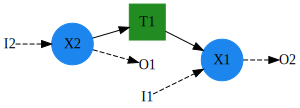

In [164]:
σ() = OpenModel([1,2], NullModel(2), [2,1])
spontaneousdag = compose(σ(), spontaneous)
display(spontaneousdag)

We now have everything we need to make an SIS model. The `odeexpr` function converts a petri net into a program for evaluating the corresponding differential equations. 

odeexpr(sis) = quote
    ##state#379(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₂) / N(u) + T[2] * u.X₂
                du.X₂ = (2 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[1] * u.X₁ * u.X₂) / N(u) + -1 * T[2] * u.X₂
            end
        end
end
Domain: [1, 2]
Codomain: [2, 1]
Model: Model(S=[1, 2], Δ=[X₁() + X₂()→2 * X₂(), X₂()→X₁()])




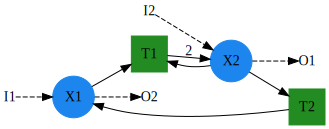

In [165]:
sis = compose(infect, spontaneousdag)
@show odeexpr(sis)
display(sis)

The SIR model can be built from these primitives too. We use the $a\otimes I; I \otimes b$ pattern to introduce a third variable $X_3=R$

odeexpr(sir) = quote
    ##state#380(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₂) / N(u)
                du.X₃ = T[2] * u.X₂
                du.X₂ = (2 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[1] * u.X₁ * u.X₂) / N(u) + -1 * T[2] * u.X₂
            end
        end
end
Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3], Δ=[X₁() + X₂()→2 * X₂(), X₂()→X₃()])




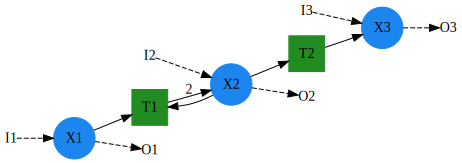

In [166]:
sir = compose(infect⊗eye(1), eye(1)⊗spontaneous)
@show odeexpr(sir)
display(sir)

Every model you build is a new primitive that you can use to make more complex models. For example $sir\otimes sir$ is two uncoupled diseases.

Domain: [1, 2, 3, 4, 5, 6]
Codomain: [1, 2, 3, 4, 5, 6]
Model: Model(S=[1, 2, 3, 4, 5, 6], Δ=[X₁() + X₂()→2 * X₂(), X₂()→X₃(), X₄() + X₅()→2 * X₅(), X₅()→X₆()])




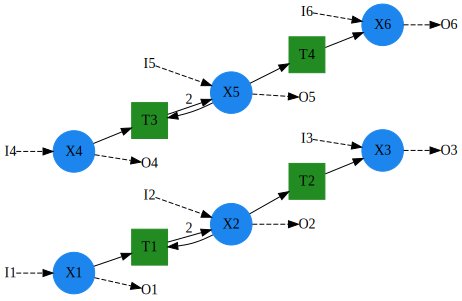

In [167]:
display(sir⊗sir)

But real world systems don't combine independently all too often, we need a way to couple things. The family of models $m_{i,j}$ combine the $i$th and $j$th input states into one input state, by taking the disjoint union of their transitions. We can use these models to combine systems by "state sharing"


Parallel Infections reactions infect ⊗ infect = X₁+X₂→ 2X₂ && X₃ +X₄ → 2X₄
Domain: [1, 2, 3, 4]
Codomain: [2, 4]
Model: Model(S=[1, 2, 3, 4], Δ=[X₁() + X₂()→2 * X₂(), X₃() + X₄()→2 * X₄()])




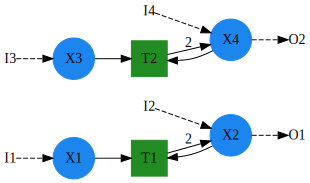

In [168]:
m₁₂ = OpenModel([1,2], NullModel(2), [1,1])
m₁₃ = OpenModel([1,2,3], NullModel(3), [1,2,1,3])

println("\nParallel Infections reactions infect ⊗ infect = X₁+X₂→ 2X₂ && X₃ +X₄ → 2X₄")
# set the codomains to be narrower to help with composition
infect′ = OpenModel([1,2], infect.model, [2])
spontaneous′ = OpenModel([1], spontaneous.model, [2])
parinfect′ = infect′ ⊗ infect′
display(parinfect′)

Domain: [1, 2, 3]
Codomain: [2, 3]
Model: Model(S=[1, 2, 3], Δ=[X₁() + X₂()→2 * X₂(), X₁() + X₃()→2 * X₃()])




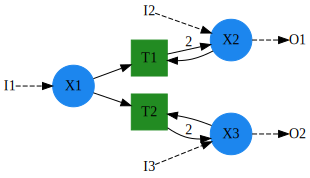

In [169]:
competing_disease = compose(m₁₃, parinfect′) 
display(competing_disease)

Domain: [1, 3]
Codomain: [2, 4]
Model: Model(S=[1, 2, 3, 4], Δ=[X₁()→X₂(), X₃()→X₄()])




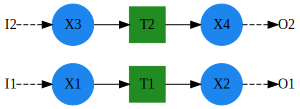

In [170]:
display(spontaneous′⊗spontaneous′)

Domain: [1, 2]
Codomain: [3]
Model: Model(S=[1, 2, 3], Δ=[X₁()→X₃(), X₂()→X₃()])




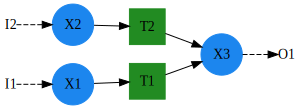

In [171]:
mutrec = OpenModel([1,2], Model([1,2,3], [(X[1],X[3]), (X[2], X[3])]), [3])
display(mutrec)

Domain: [1, 2, 3]
Codomain: [6]
Model: Model(S=[1, 2, 3, 4, 5, 6], Δ=[X₁() + X₂()→2 * X₂(), X₁() + X₃()→2 * X₃(), X₂()→X₄(), X₃()→X₅(), X₄()→X₆(), X₅()→X₆()])




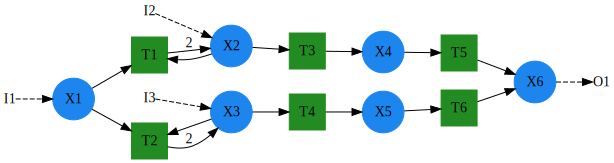

In [172]:
siir = compose(competing_disease, spontaneous′⊗spontaneous′, mutrec)
display(siir)

An interesting lemma is that if you have an OpenModel $f$ and a pair of states $x,y$ with no common transition, such that $x\notin dom(f)$ and $y \notin codom(f)$ there is no OpenModel $g$ such that $f;g$ (or $g;f$) has a transition between $x,y$. 

This is why we prefer to define primitives such that $dom(f) = codom(f) = States(f)$ when convenient.


Testing the compose and otimes with parallel;(infect ⊗ I₂)
OpenModel:4→4 with Model(∣S∣=4,∣Δ∣=3)
Domain: [1, 2, 3, 4]
Codomain: [1, 2, 3, 4]
Model: Model(S=[1, 2, 3, 4], Δ=[X₁()→X₂(), X₃()→X₄(), X₁() + X₂()→2 * X₂()])




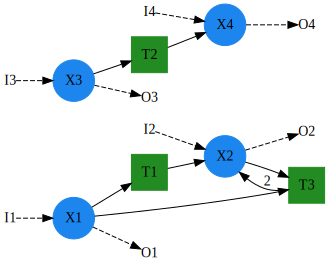

In [173]:
println("\nTesting the compose and otimes with parallel;(infect ⊗ I₂)")
m1 = compose(parallel, infect ⊗ eye(2))
println(m1)
debug_show(m1)

## Ecological Models

In [174]:
println("\nCreating food web processes birth, death, predation")
birth   = Model([1], [(X[1], 2X[1])])
death   = Model([1, 2], [(X[1], X[2])])
pred(α,β,γ) = Model([1, 2], [(α*X[1] + β*X[2], γ*X[2])])

b = OpenModel([1], birth, [1])
d = OpenModel([1], death, [1])
p(α, β, γ) = OpenModel([1,2], pred(α, β, γ), [1,2])
println("\nCreating food web processes σ, predation†")

pdag(α,β,γ) = OpenModel([1,2], Model([1, 2], [(α*X[2] + β*X[1], γ*X[1])]), [1,2])

# Catlab expressions for our variables
Xob = Ob(FreeSymmetricMonoidalCategory, :X)
idₓ = id(Xob)
σh = braid(Xob, Xob)
bh = Hom(:birth, Xob,Xob)
dh = Hom(:death, Xob, Xob)
ph = Hom(:predation, Xob^2, Xob^2)
pdagh = Hom(Symbol("p⋆"), Xob^2, Xob^2)
lookuptable = Dict( idₓ=>eye(1), σh=>σ(), bh=>b, dh=>d, ph=>p(1,1,2))
set_primitive!(ctx::Dict, hom, f::OpenModel) = begin
    ctx[hom] = f
    return ctx
end
set_primitive(hom, f::OpenModel) = set_primitive!(lookuptable, hom, f)
compile(x) = compile(x, lookuptable)


Creating food web processes birth, death, predation

Creating food web processes σ, predation†


compile (generic function with 4 methods)

## The Lotka Volterra Model

A simple model of predator-prey dynamics that is widely used in ecology is the Lotka-Volterra model. The prey species grows exponentially, and is eaten by a predator species that suffers from contant probability of death (exponential decay). This model has periodic solutions that are non-trigonometric.


<img src="./img/lotka_volterra_concept.svg" width="45%">

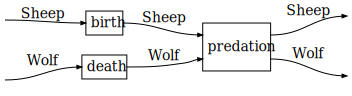

In [175]:
bd = b⊗d
lvh = compose(bh⊗dh, ph)
display(wd(lvh), [:Wolf, :Sheep, :Wolf, :Sheep, :Wolf,:Sheep])

OpenModel:2→2 with Model(∣S∣=3,∣Δ∣=3)
odeexpr(lv) = quote
    ##state#381(du, u, T, t) = begin
            begin
                du.X₁ = 2 * T[1] * u.X₁ + -1 * T[1] * u.X₁ + (-1 * T[3] * u.X₁ * u.X₂) / N(u)
                du.X₃ = T[2] * u.X₂
                du.X₂ = -1 * T[2] * u.X₂ + (2 * T[3] * u.X₁ * u.X₂) / N(u) + (-1 * T[3] * u.X₁ * u.X₂) / N(u)
            end
        end
end
Domain: [1, 2]
Codomain: [1, 2]
Model: Model(S=[1, 2, 3], Δ=[X₁()→2 * X₁(), X₂()→X₃(), 1 * X₁() + 1 * X₂()→2 * X₂()])




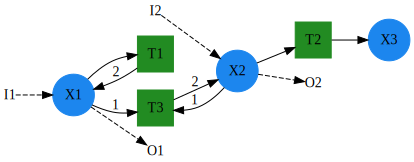

In [176]:
lv = compile(lvh)
println(lv)
@show odeexpr(lv)
display(lv)


### Food Chain

The first predator is the second prey

<img src="./img/foodchain_concept.svg" width="50%">


bdd = b⊗d⊗d

bdb = b⊗d⊗b
bipredation is (p⊗I)⊚(I⊗p)

foodchain is (bipredation)⊚(bdd). A fish, a bigger fish, and biggest fish
Cannonical form construction proves:  compose(otimes(predation,id(X)),otimes(id(X),predation),otimes(birth,death,death)) == compose(otimes(predation,id(X)),otimes(birth,compose(predation,otimes(death,death))))


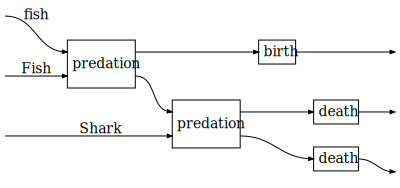

In [177]:
println("\nbdd = b⊗d⊗d")
bdd = bd⊗d
println("\nbdb = b⊗d⊗b")
bdb = b⊗(d⊗b)
println("bipredation is (p⊗I)⊚(I⊗p)")
bipredation = compose(p(1,1,2)⊗eye(1), eye(1)⊗p(1,1,2))
println("\nfoodchain is (bipredation)⊚(bdd). A fish, a bigger fish, and biggest fish")
foodchainh = compose(ph⊗idₓ, idₓ⊗ph, bh⊗dh⊗dh)
homx = SemanticModels.ModelTools.WiringDiagrams.canonical(FreeSymmetricMonoidalCategory, foodchainh)
println("Cannonical form construction proves:  $foodchainh == $homx")
#drawhom(foodchainh, "img/foodchain_wd")
display(wd(foodchainh), [:fish, :Fish, :Shark])

Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3, 4, 5], Δ=[1 * X₁() + 1 * X₂()→2 * X₂(), 1 * X₂() + 1 * X₃()→2 * X₃(), X₁()→2 * X₁(), X₂()→X₄(), X₃()→X₅()])




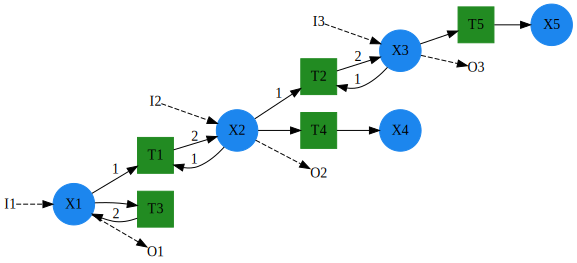

In [178]:
foodchain = compile(foodchainh)
display(foodchain)

In [179]:
#compile(foodchainh) == foodchain

In [180]:
println("As an ordinary differential equation:")
odeexpr(foodchain).args[end].args[end].args[end]

As an ordinary differential equation:


quote
    du.X₁ = (-1 * T[1] * u.X₁ * u.X₂) / N(u) + 2 * T[3] * u.X₁ + -1 * T[3] * u.X₁
    du.X₅ = T[5] * u.X₃
    du.X₄ = T[4] * u.X₂
    du.X₃ = (2 * T[2] * u.X₂ * u.X₃) / N(u) + (-1 * T[2] * u.X₂ * u.X₃) / N(u) + -1 * T[5] * u.X₃
    du.X₂ = (2 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[2] * u.X₂ * u.X₃) / N(u) + -1 * T[4] * u.X₂
end


### Food Star

The first predator is the second predator (with two independent prey species)

<img src="./img/foodstar_concept.svg" width="50%">

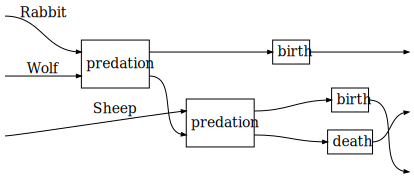

In [181]:
foodstarh = compose(ph⊗idₓ, idₓ⊗compose(σh,ph, σh), bh⊗dh⊗bh)
display(wd(foodstarh), [:Rabbit, :Wolf, :Sheep])

OpenModel:3→3 with Model(∣S∣=4,∣Δ∣=5)
Cannonical form construction proves:  compose(otimes(predation,id(X)),otimes(id(X),compose(braid(X,X),predation,braid(X,X))),otimes(birth,death,birth)) == compose(otimes(predation,id(X)),otimes(id(X),braid(X,X)),otimes(birth,compose(predation,otimes(birth,death))),otimes(id(X),braid(X,X)))
As an ordinary differential equation:
odeexpr(foodstar) = quote
    ##state#383(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₂) / N(u) + 2 * T[3] * u.X₁ + -1 * T[3] * u.X₁
                du.X₄ = T[4] * u.X₂
                du.X₃ = (-1 * T[2] * u.X₃ * u.X₂) / N(u) + 2 * T[5] * u.X₃ + -1 * T[5] * u.X₃
                du.X₂ = (2 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[1] * u.X₁ * u.X₂) / N(u) + (2 * T[2] * u.X₃ * u.X₂) / N(u) + (-1 * T[2] * u.X₃ * u.X₂) / N(u) + -1 * T[4] * u.X₂
            end
        end
end
Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3, 4], Δ=[1 * X₁() + 1 * X₂()→2 * X₂(), 1 * X₃() + 1 * X₂

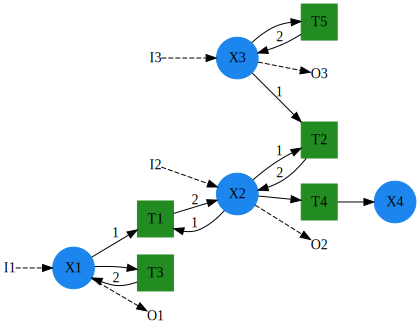

In [182]:
foodstar = compile(foodstarh) 
println(foodstar)

homx = canonical(FreeSymmetricMonoidalCategory, foodstarh)
println("Cannonical form construction proves:  $foodstarh == $homx")
println("As an ordinary differential equation:")
@show odeexpr(foodstar)
display(foodstar)

## Malaria


<img src="./img/malaria_concept.svg" width="25%">

In [183]:
dualinfect = compose(ph⊗idₓ, idₓ⊗pdagh)
cur = Hom(:cure, Xob⊗Xob, Xob⊗Xob)
curdag = Hom(Symbol("cur⋆"), Xob^2, Xob^2)
inf = Hom(Symbol("inf¹³₂₃"), Xob^3, Xob^3)

#inf′ = Hom(Symbol("inf³¹₂₁"), Xob^3, Xob^3)
#malariah = compose(inf⊗idₓ, idₓ⊗compose(compose(σh⊗idₓ, idₓ⊗σh), inf, compose(idₓ⊗idₓ⊗idₓ, idₓ⊗σh, σh⊗idₓ)),cur⊗conj(cur, σh))
malariah = compose(inf⊗idₓ, idₓ⊗compose(σh⊗idₓ, idₓ⊗σh, σh⊗idₓ), idₓ⊗inf, idₓ⊗conj(σh⊗idₓ, idₓ⊗σh), cur⊗compose(σh, cur, σh))
#drawhom(malariah, "img/malaria_wd")

compose(otimes(inf¹³₂₃,id(X)),otimes(id(X),compose(otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)))),otimes(id(X),inf¹³₂₃),otimes(id(X),compose(otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)))),otimes(cure,compose(braid(X,X),cure,braid(X,X))))

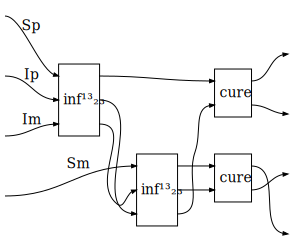

In [184]:
display(wd(malariah), ["Sp", "Ip", "Im", "Sm"])

Domain: [1, 2]
Codomain: [1, 2]
Model: Model(S=[1, 2], Δ=[X₂()→X₁(), X₂()→X₁()])




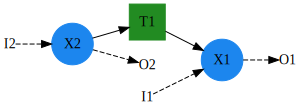

In [185]:
cure = conj(spontaneous, σ())
display(cure)

In [186]:
curedag = op(cure)
curedag == spontaneous

true

In order to build the mosquito borne illness model, we need a new primative. In this case $X_1 + X_3 \rightarrow X_2 + X_3$ 

Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3], Δ=[X₁() + X₃()→X₂() + X₃(), X₁() + X₃()→X₂() + X₃()])




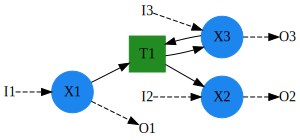

In [187]:
trinary  = OpenModel([1,2,3], Model([1,2,3], [(X[1]+X[3], X[2]+X[3])]), [1,2,3])
set_primitive(inf, trinary)
display(trinary)

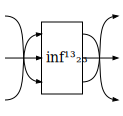

In [188]:
inf′ = compose(σh⊗idₓ, idₓ⊗σh, σh⊗idₓ, inf, conj(σh⊗idₓ, idₓ⊗σh))
display(wd(inf′))

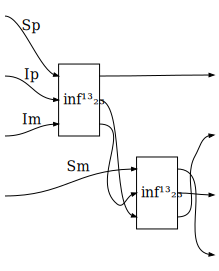

In [189]:
dualinfecth = compose(inf⊗idₓ, idₓ⊗inf′)
display(wd(dualinfecth), ["Sp", "Ip","Im","Sm"])

Domain: [1, 2, 3, 4]
Codomain: [1, 2, 3, 4]
Model: Model(S=[1, 2, 3, 4], Δ=[X₁() + X₃()→X₂() + X₃(), X₄() + X₂()→X₃() + X₂()])




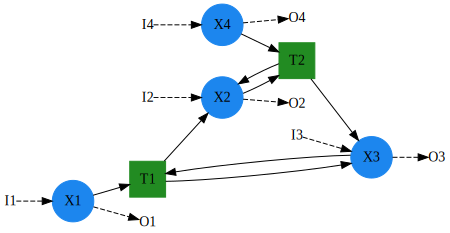

In [190]:
dualinfect = compile(dualinfecth)
display(dualinfect)

Cannonical form construction proves:
	  compose(otimes(inf¹³₂₃,id(X)),otimes(id(X),compose(otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)))),otimes(id(X),inf¹³₂₃),otimes(id(X),compose(otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)))),otimes(cure,compose(braid(X,X),cure,braid(X,X)))) 
	== 
	  compose(otimes(inf¹³₂₃,id(X)),otimes(id(X),braid(X,X),id(X)),otimes(id(otimes(X,X)),braid(X,X)),otimes(id(X),braid(X,X),id(X)),otimes(id(X),inf¹³₂₃),otimes(id(otimes(X,X)),braid(X,X)),otimes(id(X),braid(X,X),id(X)),otimes(cure,cure),otimes(id(otimes(X,X)),braid(X,X)))
As an ordinary differential equation:
odeexpr(malaria) = quote
    ##state#384(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₃) / N(u) + T[3] * u.X₂
                du.X₄ = (-1 * T[2] * u.X₄ * u.X₂) / N(u) + T[4] * u.X₃
                du.X₃ = (T[1] * u.X₁ * u.X₃) / N(u) + (-1 * T[1] * u.X₁ * u.X₃) / N(u) + (T[2] * u.X₄ * u.X₂) / N(u) + -1 * 

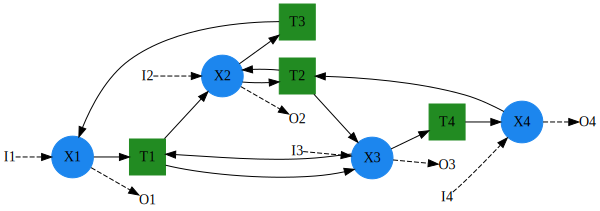

In [191]:
set_primitive(ph, p(1,1,1.15))
set_primitive(cur, cure)
set_primitive(inf, trinary)
#lookuptable = Dict(bh=>b, dh=>d, σh=>σ(), ph=>p(1,1,1.15), inf=>trinary,idₓ=>eye(1), cur=>cure)
malaria = compile(malariah)
homx = canonical(FreeSymmetricMonoidalCategory, malariah)
println("Cannonical form construction proves:\n\t  $malariah \n\t== \n\t  $homx")
println("As an ordinary differential equation:")
@show odeexpr(malaria)
debug_show(malaria, "img/malaria.svg")

In [192]:
f = Petri.mk_function(malaria.model)

#65 (generic function with 1 method)

In [193]:
u0 = @LArray [20,1,0,100.0] (:X₁, :X₂, :X₃, :X₄)
varnames = ["\$S_p\$", "\$I_p\$", "\$I_m\$", "\$S_m\$"];

## Endemic Malaria
Because we assumed that Malaria is SIS for both People and Mosquitos the only solution is endemic malaria, where there is a constant fraction of infected people at equilibrium.

sol[end] = [X₁=15.732700855242287, X₂=5.267299144757728, X₃=37.20917828829352, X₄=62.79082171170651]


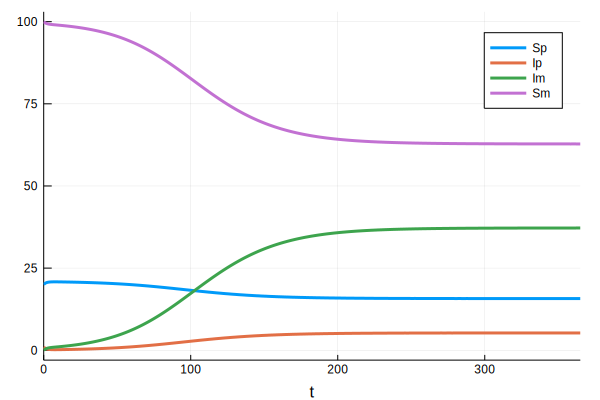

In [194]:
βpm = 0.0045
βmp = 0.0045
ρp = 0.5
ρm = 0.04
νp = 0.006

νm = 0.1

params = [βpm, βmp,ρp,ρm]
prob = ODEProblem(f,u0,(0.0,365.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sp, :Ip, :Im, :Sm, :Dp, :Dm]

plt = plot(sol, vars =1:length(varnames)-2, labels=varnames)

savefig(plt, "img/malaria_sol_endemic.png")
plt

# Malaria Driven Extinction

In the case where malaria is fatal to some fraction of the population and you start off with more mosquitos than people:

    Blessed are the mosquitos, for they shall inherit the earth

In [195]:
malvitalh = compose(malariah, bh⊗dh⊗dh⊗bh)

compose(otimes(inf¹³₂₃,id(X)),otimes(id(X),compose(otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)))),otimes(id(X),inf¹³₂₃),otimes(id(X),compose(otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)))),otimes(cure,compose(braid(X,X),cure,braid(X,X))),otimes(birth,death,death,birth))

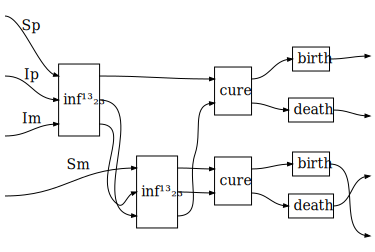

In [196]:
display(wd(malvitalh), ["Sp", "Ip","Im","Sm"])

Domain: [1, 2, 3, 4]
Codomain: [1, 2, 3, 4]
Model: Model(S=[1, 2, 3, 4, 5, 6], Δ=[X₁() + X₃()→X₂() + X₃(), X₄() + X₂()→X₃() + X₂(), X₂()→X₁(), X₃()→X₄(), X₁()→2 * X₁(), X₂()→X₅(), X₃()→X₆(), X₄()→2 * X₄()])




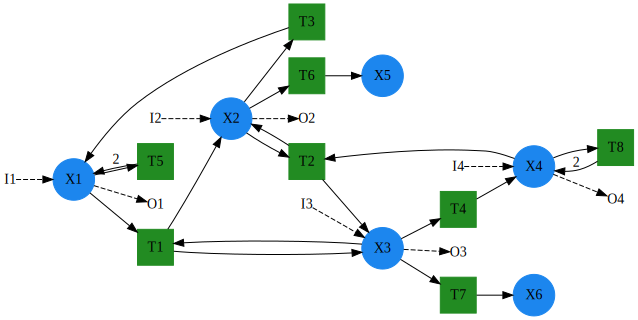

In [197]:
malvital = compile(malvitalh); #compose(malaria, b⊗d⊗d⊗b)
display(malvital)

In [198]:
println("As an ordinary differential equation:")
@show fex = odeexpr(malvital)
f = Petri.mk_function(malvital.model)

As an ordinary differential equation:
fex = odeexpr(malvital) = quote
    ##state#387(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₃) / N(u) + T[3] * u.X₂ + 2 * T[5] * u.X₁ + -1 * T[5] * u.X₁
                du.X₅ = T[6] * u.X₂
                du.X₄ = (-1 * T[2] * u.X₄ * u.X₂) / N(u) + T[4] * u.X₃ + 2 * T[8] * u.X₄ + -1 * T[8] * u.X₄
                du.X₆ = T[7] * u.X₃
                du.X₃ = (T[1] * u.X₁ * u.X₃) / N(u) + (-1 * T[1] * u.X₁ * u.X₃) / N(u) + (T[2] * u.X₄ * u.X₂) / N(u) + -1 * T[4] * u.X₃ + -1 * T[7] * u.X₃
                du.X₂ = (T[1] * u.X₁ * u.X₃) / N(u) + (T[2] * u.X₄ * u.X₂) / N(u) + (-1 * T[2] * u.X₄ * u.X₂) / N(u) + -1 * T[3] * u.X₂ + -1 * T[6] * u.X₂
            end
        end
end


#65 (generic function with 1 method)

In [199]:
u0 = @LArray [20,1,0,100,0.1,0] (:X₁, :X₂, :X₃, :X₄, :X₅, :X₆)
varnames = ["\$S_p\$", "\$I_p\$", "\$I_m\$", "\$S_m\$", "\$Dp\$", "\$Dm\$"];

sol[end] = [X₁=0.118672823642017, X₂=0.6300807358280642, X₃=15.66598215784487, X₄=115.38905945308686, X₅=25.773026412722405, X₆=152.68431308544328]


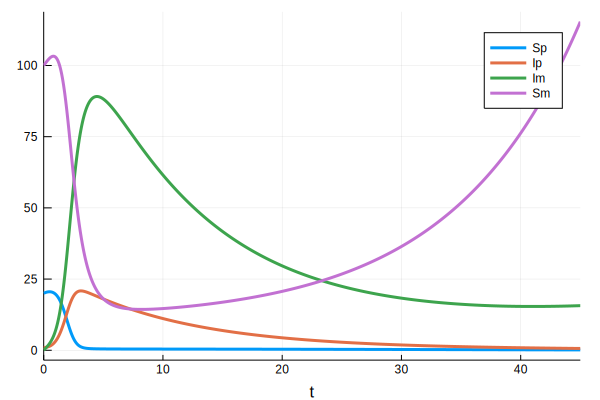

In [200]:
βpm = 0.045
βmp = 0.045
ρp = 0.1
ρm = 0.1
νp = 0.1
δp = 0.1
δm = 0.1
νm = 0.1

params = [βpm, βmp,ρp,ρm, νp, δp, δm, νm]
prob = ODEProblem(f,u0,(0.0,45.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sp, :Ip, :Im, :Sm, :Dp, :Dm]

plt = plot(sol, vars =1:length(varnames)-2, labels=varnames)
# ylims!(plt, (0,100))
# xlims!(plt, (0,50))
# yaxis!("amount", :log10)
savefig(plt, "img/malaria_sol_fatal.png")
plt

## Endemic Malaria with Vital dynamics


In [201]:
u0 = @LArray [20,1,0,100,0.1,0] (:X₁, :X₂, :X₃, :X₄, :X₅, :X₆)
varnames = ["\$S_p\$", "\$I_p\$", "\$I_m\$", "\$S_m\$", "\$Dp\$", "\$Dm\$"];

sol[end] = [X₁=7.925128113171479, X₂=63.53298752007829, X₃=116.96980173521904, X₄=24.601033560805966, X₅=495.33260872620883, X₆=345.1517256206875]


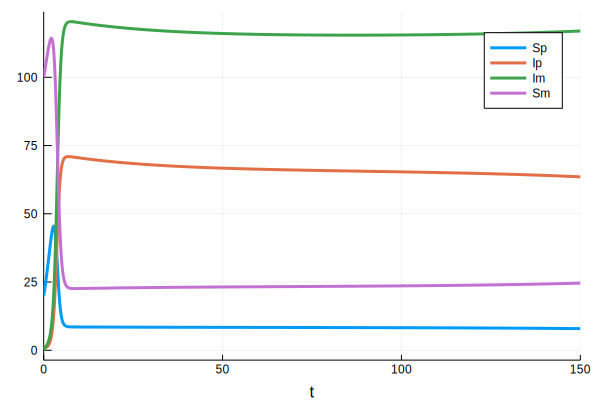

In [202]:
βpm = 0.024
βmp = 0.024
ρp = 0.3
ρm = 0.3
νp = 0.4
δp = 0.051
δm = 0.02025
νm = 0.1

params = [βpm, βmp,ρp,ρm, νp, δp, δm, νm]
prob = ODEProblem(f,u0,(0.0,150.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sp, :Ip, :Im, :Sm, :Dp, :Dm]

plt = plot(sol, vars =1:length(varnames)-2, labels=varnames)
# ylims!(plt, (0,100))
# xlims!(plt, (0,50))
# yaxis!("amount", :log10)
savefig(plt, "img/malaria_sol_fatal.png")
plt

## Mosquito Hunting Birds

We want to perform cross domain model fusion, by incorporated ecology into our epidemiology. This means adding a species of birds that eat the mosquitos.

<img src="./img/birdmal_concept.svg" width="33%">

This gives rise to the following high level model structure. Where `malaria, mutual predation,` and `vitals` are submodels 

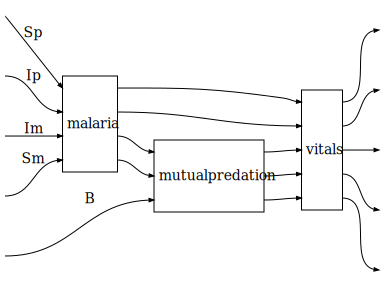

In [262]:
display(wd(compose(Hom(:malaria, Xob^4, Xob^4)⊗idₓ, idₓ^2⊗Hom(:mutualpredation, Xob^3, Xob^3), Hom(:vitals, Xob^5, Xob^5))), [:B, :Sp, :Ip, :Im, :Sm])

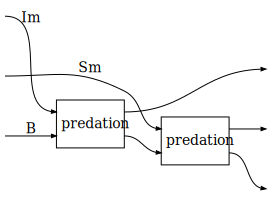

In [263]:
birdsh = compose(σh⊗idₓ,idₓ⊗ph, σh⊗idₓ, idₓ⊗ph)
display(wd(birdsh), [:Im, :B, :Sm])

Cannonical form construction proves:  compose(otimes(braid(X,X),id(X)),otimes(id(X),predation),otimes(braid(X,X),id(X)),otimes(id(X),predation)) == compose(otimes(braid(X,X),id(X)),otimes(id(X),predation),otimes(braid(X,X),id(X)),otimes(id(X),predation))


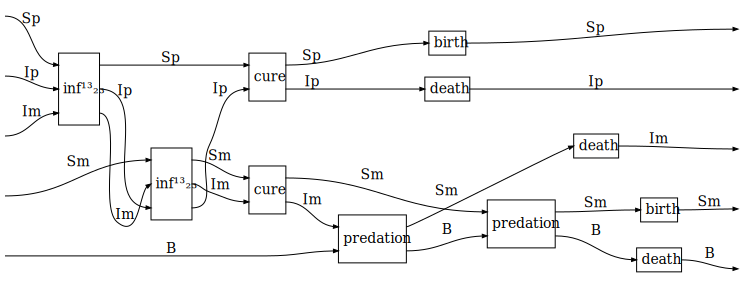

In [264]:
drawhom(birdsh, "img/birds_wd")
homx = canonical(FreeSymmetricMonoidalCategory, birdsh)
println("Cannonical form construction proves:  $birdsh == $homx")
# vitals for Sp, Ip, Im, Sm, B are:
# born, die (of malaria), die (of malaria), born, die (starvation)
vitalsh = bh⊗dh⊗dh⊗bh⊗dh
#birdmalh = compose(malvitalh⊗idₓ, idₓ^2⊗compose(birdsh, idₓ^2⊗dh))
birdmalh = compose(malariah⊗ idₓ, idₓ^2⊗birdsh, vitalsh)
drawhom(birdmalh, "img/birdmal_wd")
display(wd(birdmalh), [:B, :Sp, :Ip, :Im, :Sm, :Sm, :Ip,:B,:Sm,:Sm, :B,:Im,:Ip, :Sp,:Ip,:Sm,:Im, :Ip,:Sp,:Im,:Sm,:Im, :B, :Sp])

Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3], Δ=[1 * X₁() + 1 * X₃()→1.15 * X₃(), 1 * X₂() + 1 * X₃()→1.15 * X₃()])


Domain: [1, 2, 3, 4, 5]
Codomain: [1, 2, 3, 4, 5]
Model: Model(S=[1, 2, 3, 4, 5, 6, 7, 8], Δ=[X₁() + X₃()→X₂() + X₃(), X₄() + X₂()→X₃() + X₂(), X₂()→X₁(), X₃()→X₄(), 1 * X₃() + 1 * X₅()→1.15 * X₅(), 1 * X₄() + 1 * X₅()→1.15 * X₅(), X₁()→2 * X₁(), X₂()→X₆(), X₃()→X₇(), X₄()→2 * X₄(), X₅()→X₈()])


Domain: Any[]
Codomain: Any[]
Model: Model(S=[1, 2, 3, 4, 5, 6, 7, 8], Δ=[X₁() + X₃()→X₂() + X₃(), X₄() + X₂()→X₃() + X₂(), X₂()→X₁(), X₃()→X₄(), 1 * X₃() + 1 * X₅()→1.15 * X₅(), 1 * X₄() + 1 * X₅()→1.15 * X₅(), X₁()→2 * X₁(), X₂()→X₆(), X₃()→X₇(), X₄()→2 * X₄(), X₅()→X₈()])




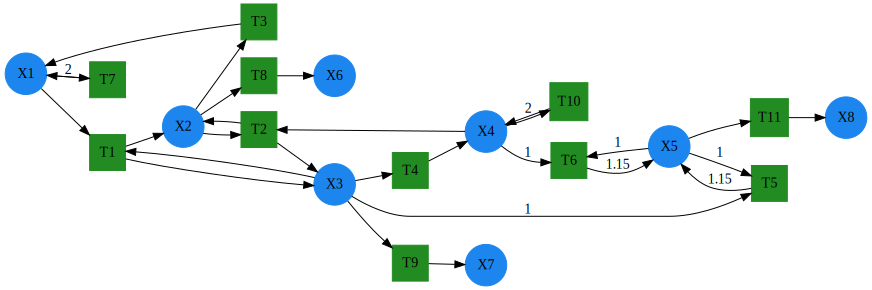

In [205]:
birds = compose(σ()⊗eye(1), eye(1)⊗p(1,1,1.15), σ()⊗eye(1), eye(1)⊗p(1,1,1.15))
debug_show(birds, "img/birds.svg")
birdmal = compile(birdmalh)
debug_show(birdmal, "img/birdmal.svg")
display(OpenModel([], birdmal.model, []))

In [206]:
# homx = canonical(FreeSymmetricMonoidalCategory, birdmalh)
# println("Cannonical form construction proves:\n\t$birdmalh\n\t  ==\n\t$homx")

In [207]:
println("As an ordinary differential equation:")
fex = @show odeexpr(birdmal)
Petri.N(s) = 1 #sum(s[1:end-3])
f = Petri.mk_function(birdmal.model)

As an ordinary differential equation:
odeexpr(birdmal) = quote
    ##state#391(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₃) / N(u) + T[3] * u.X₂ + 2 * T[7] * u.X₁ + -1 * T[7] * u.X₁
                du.X₅ = (1.15 * T[5] * u.X₃ * u.X₅) / N(u) + (-1 * T[5] * u.X₃ * u.X₅) / N(u) + (1.15 * T[6] * u.X₄ * u.X₅) / N(u) + (-1 * T[6] * u.X₄ * u.X₅) / N(u) + -1 * T[11] * u.X₅
                du.X₄ = (-1 * T[2] * u.X₄ * u.X₂) / N(u) + T[4] * u.X₃ + (-1 * T[6] * u.X₄ * u.X₅) / N(u) + 2 * T[10] * u.X₄ + -1 * T[10] * u.X₄
                du.X₆ = T[8] * u.X₂
                du.X₇ = T[9] * u.X₃
                du.X₈ = T[11] * u.X₅
                du.X₃ = (T[1] * u.X₁ * u.X₃) / N(u) + (-1 * T[1] * u.X₁ * u.X₃) / N(u) + (T[2] * u.X₄ * u.X₂) / N(u) + -1 * T[4] * u.X₃ + (-1 * T[5] * u.X₃ * u.X₅) / N(u) + -1 * T[9] * u.X₃
                du.X₂ = (T[1] * u.X₁ * u.X₃) / N(u) + (T[2] * u.X₄ * u.X₂) / N(u) + (-1 * T[2] * u.X₄ * u.X₂) / N(u) + -1 * T[3] * u.X₂ + -1 * T

#65 (generic function with 1 method)

In [208]:
u0 = @LArray [20,1,0,100,0.2,0,0,0.0] (:X₁, :X₂, :X₃, :X₄, :X₅, :X₆, :X₇, :X₈)
varnames = ["\$S_p\$", "\$I_p\$", "\$I_m\$", "\$S_m\$", "\$B\$", "\$Dp\$", "\$Dm\$", "\$D_b\$"];

## Malaria Driven Extinction

In the followin setting everyone dies, but then the mosquito population becomes locked in a Lotka-Volterra struggle for the earth.

sol[end] = [X₁=0.6518804960409814, X₂=3.9411540896561354e-10, X₃=1.9924967895384285e-8, X₄=56.276722842307045, X₅=0.0011281237872835719, X₆=21.23354569504563, X₇=4.831252597542185, X₈=112.68585807143518]


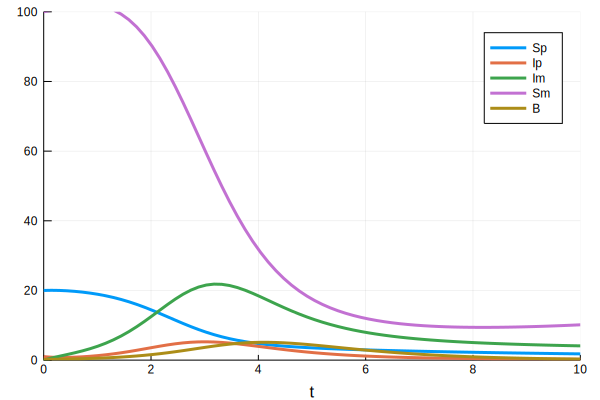

In [209]:
βpm = 0.045
βmp = 0.045
ρp = 0.5
ρm = 0.04
ηI = 0.12
ηS = 0.12
νp = 0.006
δp = 1.0
δm = 0.03
νm = 0.1
δb = 0.85
params = [βpm, βmp,ρp,ρm,ηI, ηS, νp, δp, δm, νm, δb]
prob = ODEProblem(f,u0,(0.0, 160.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sp, :Ip, :Im, :Sm, :B, :Dp, :Dm,:Db]
plotvars = [1,2,3,4,5]
plt = plot(sol, vars =plotvars, labels=varnames[plotvars])
ylims!(plt, (0,100))
xlims!(plt, (0,10))
# yaxis!("amount", :log10)
savefig(plt, "img/birdmal_sol_subcritical.png")
plt

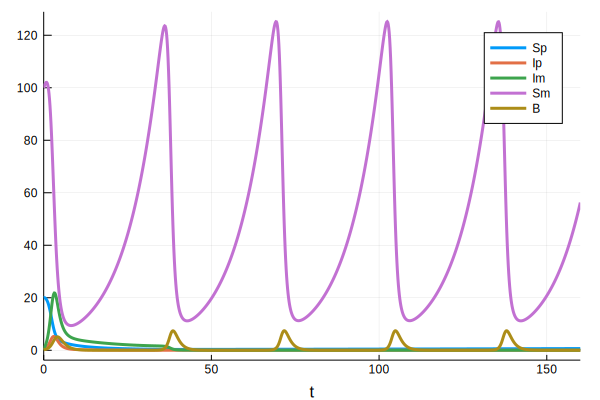

In [210]:
plt = plot(sol, vars =1:length(varnames)-3, labels=varnames)
#yaxis!(plt, (0,30))

## Endemic Malaria

In the following example, malaria is endemic and cyclical within a population. After a phase of initially wild fluctuation, we settle down into a rythm of cyclic epidemics. The exponential growth and decay cycles are driven by the Lotka Volterra dynamics between the birds and the mosquitos.

sol[end] = [X₁=7.712551519101319, X₂=0.6319683940025463, X₃=4.833423048061268, X₄=106.28898842352022, X₅=22.71548262951343, X₆=5139.821778500151, X₇=288.4689530404894, X₈=2948.9339811585596]


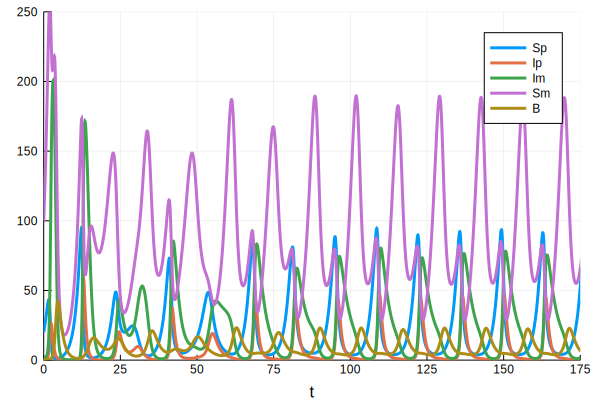

In [211]:
βpm = 0.045
βmp = 0.045
ρp = 1.2
ρm = 0.4
ηI = 0.05
ηS = 0.05
νp = 0.600
δp = 1.9
δm = 0.03
νm = 0.6
δb = 0.85
params = [βpm, βmp,ρp,ρm,ηI, ηS, νp, δp, δm, νm, δb]
prob = ODEProblem(f,u0,(0.0,375.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

plt = plot(sol, vars =1:length(varnames)-3, labels=varnames)
ylims!(plt, (0,250))
xlims!(plt, (0,175))
savefig(plt, "img/birdmal_sol_multiepi.pdf")
plt

Zooming in on a cycle you can see that the mosquitos and birds interact with a mixture of Lotka Volterra dynamics and SIS dynamics. The population of birds tracks the population of mosquitos, as the number of birds increases, they drive mosquitos to near extinction. Once there are no birds to eat the mosquitos, the population of mosquitos explodes. At this point the human population has rebounded and is decimated by an epdidemic of malaria. The epidemic ends when the number of human hosts is small enough to all for recovery of the infected mosquitos. Recall that we assumed that Malaria is (SISD) in both people and mosquitos.


The coupled model of Malaria (without Vital Dynamics): 
- $X_1\rightarrow S_p$
- $X_2\rightarrow I_p$
- $X_3\rightarrow I_m$
- $X_4\rightarrow S_m$

![The coupled model of Malaria (without Vital Dynamics)](./img/malaria.svg)

You can see from the zoomed in plot that the malaria outbreaks occur approximately half a cycle shifted from the Lotka Volterra cycle in the mosquito population.

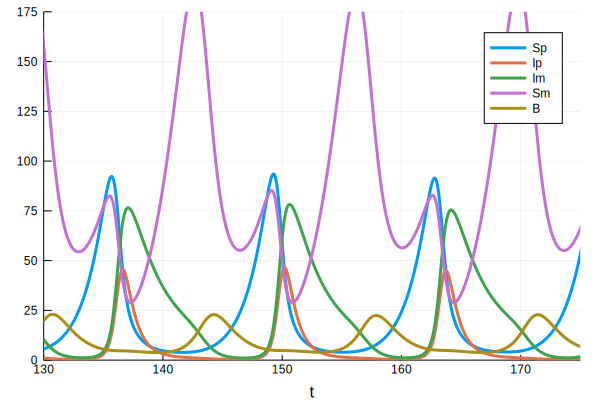

In [212]:
plt = plot(sol, vars =1:length(varnames)-3, labels=varnames)
ylims!(plt, (0,175))
xlims!(plt, (130,175))
savefig(plt, "img/birdmal_sol_multiepi_zoom.pdf")
plt

## Unstable System

The following choice of parameters exhibits an unstable dynamics, without approaching a periodic equilibrium.

sol[end] = [X₁=11.123283077257447, X₂=0.5143960076735042, X₃=0.8427716284564659, X₄=22.263838461449144, X₅=3.5196619156057465, X₆=354.21035812351687, X₇=20.29087996476093, X₈=353.48953852335836]


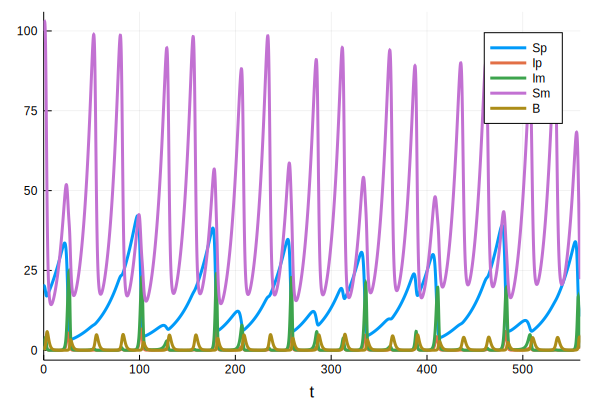

In [213]:
βpm = 0.045
βmp = 0.045
ρp = 0.5
ρm = 0.05
ηI = 0.6
ηS = 0.12
νp = 0.04
δp = 1.9
δm = 0.03
νm = 0.1
δb = 0.85
params = [βpm, βmp,ρp,ρm,ηI, ηS, νp, δp, δm, νm, δb]
prob = ODEProblem(f,u0,(0.0,560.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sp, :Ip, :Im, :Sm, :B, :Dp, :Dm, :Db]

plt = plot(sol, vars =1:length(varnames)-3, labels=varnames)
#ylims!(plt, (0,90))
#xlims!(plt, (0,50))
# yaxis!("amount", :log10)
savefig(plt, "img/birdmal_sol_subcritical.png")
plt

The outbreaks exhibit irregular behavior

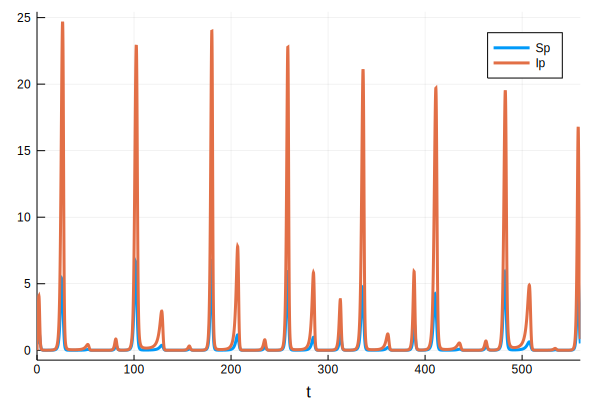

In [214]:
plt = plot(sol, vars =[2,3], labels=varnames)
#ylims!(plt, (0,10))
#xlims!(plt, (0,450))

In [215]:
# println("Testing Braiding with composition for Petri.OpenModel")
# # these examples show that σ_guess can precompose with a morphism to reverse it's two wires, it cannot post compose with it to renumber its outputs.
# # This relates to our implementation that favors f in compose(f,g), and the fact that in a PROP, all objects are natural numbers.
# # If all objects are braid(X,X) = X⊗X as objects. You can compose(braid(X,X), f) to get the version of f with the first and second state reversed, but
# # you cannot reverse the outputs because our "renumbering the states" implementation will renumber that away.
# σ_guess = OpenModel([1,2], NullModel(2), [2,1])
# f = compose(σ_guess, bd)
# debug_show(f, "img/braid_debug_precomp.svg")
# f = compose(bd, σ_guess)
# debug_show(f, "img/braid_debug_postcomp.svg")
# debug_show(bd, "img/braid_debug_btimesd.svg")
# debug_show(compose(σ_guess, p(1,2,3)), "img/braid_debug_pred.svg")
# debug_show(compose(σ_guess, eye(2)), "img/braid_debug_precompid.svg")
# debug_show(compose(σ_guess, σ_guess, eye(2)), "img/braid_debug_precomp2id.svg")
# debug_show(compose(compose(σ_guess, p(1,2,3))⊗eye(1), compose(eye(1)⊗σ_guess, eye(1)⊗p(1,2,3))), "img/braid_debug_pred2.svg")
# debug_show(σ_guess⊗σ_guess, "img/braid_debug_precomp4.svg")
# debug_show(compose(σ_guess⊗σ_guess, eye(4)), "img/braid_debug_precomp4id.svg")
# debug_show(compose(σ_guess⊗σ_guess, p(1,2,3)⊗p(2,4,6)), "img/braid_debug_precomp4psq.svg")

## Prefential predation

We can explore the impact of the feeding preferences of the birds. If they prefer to eat infected mosquitos, then they should reduce the epidemics of malaria. If they prefer to eat susceptible mosquitos, then they should bias the population towards infection and increase malaria. We don't model natural selection so these results aren't biologically meaninful, ie. the mosquitos should evolve towards a highly infectious form of malaria to avoid being eaten by birds.

sol[end] = [X₁=31.29235486237643, X₂=4.510949280967369, X₃=10.554932284715186, X₄=39.20172576953721, X₅=2.1780975912213756, X₆=90.53978045688753, X₇=9.417814727439959, X₈=126.64848867564606]
minimum((x[3] for x = sol.u[5:end - 5])) = 0.1678289324949825


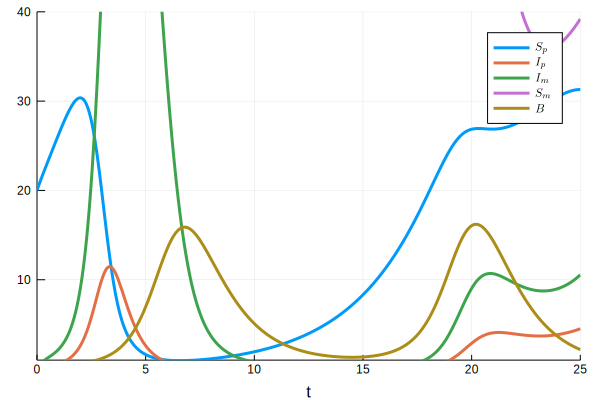

In [216]:
u0 = @LArray [20,1,0,100,0.5,0,0,0.0] (:X₁, :X₂, :X₃, :X₄, :X₅, :X₆, :X₇, :X₈)
varnames = ["\$S_p\$", "\$I_p\$", "\$I_m\$", "\$S_m\$", "\$B\$", "\$Dp\$", "\$Dm\$", "\$D_b\$"]
βpm = 0.045
βmp = 0.045
ρp = 1.2
ρm = 0.4
ηI = 0.05
ηS = 0.05
νp = 0.300
δp = 1.9
δm = 0.03
νm = 0.3
δb = 0.85
params = [βpm, βmp,ρp,ρm,ηI, ηS, νp, δp, δm, νm, δb]
prob = ODEProblem(f,u0,(0.0,25.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]
@show minimum(x[3] for x in sol.u[5:end-5])
plt = plot(sol, vars =1:length(varnames)-3, labels=varnames)
ylims!(plt, (1,40))
# xlims!(plt, (0,175))
# savefig(plt, "img/birdmal_sol_multiepi.pdf")
plt

sol[end] = [X₁=1053.2038116797148, X₂=40.76438572958252, X₃=2.2072042574052766, X₄=0.6196909130143824, X₅=1.808070010458121, X₆=454.17288459727075, X₇=2.1679708469367562, X₈=39.133571631768085]
minimum((x[3] for x = sol.u[20:end - 20])) = 1.8516986523127796


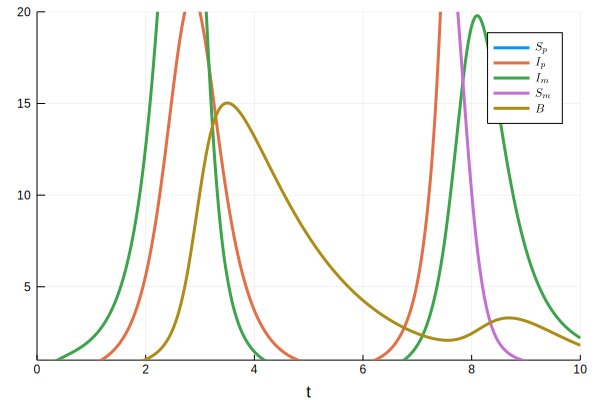

In [217]:
u0 = @LArray [20,1,0,100,0.5,0,0,0.0] (:X₁, :X₂, :X₃, :X₄, :X₅, :X₆, :X₇, :X₈)
varnames = ["\$S_p\$", "\$I_p\$", "\$I_m\$", "\$S_m\$", "\$B\$", "\$Dp\$", "\$Dm\$", "\$D_b\$"]
βpm = 0.045
βmp = 0.045
ρp = 1.2
ρm = 0.4
ηI = 0.5
ηS = 0.05
νp = 0.600
δp = 1.9
δm = 0.03
νm = 0.3
δb = 0.85
params = [βpm, βmp,ρp,ρm,ηI, ηS, νp, δp, δm, νm, δb]
prob = ODEProblem(f,u0,(0.0,10.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]
@show minimum(x[3] for x in sol.u[20:end-20])
plt = plot(sol, vars =1:length(varnames)-3, labels=varnames)
ylims!(plt, (1,20))
# xlims!(plt, (0,175))
# savefig(plt, "img/birdmal_sol_multiepi.pdf")
plt

Domain: [1, 1]
Codomain: [1]
Model: Model(S=[1], Δ=[])

Domain: [1, 3]
Codomain: [4]
Model: Model(S=[1, 2, 3, 4], Δ=[X₁()→X₂(), X₃()→X₄()])




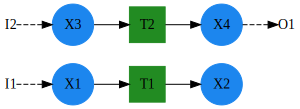

In [218]:
#TODO: this doesn't work because of an implementation bug
m12dag = OpenModel([1,1], NullModel(1), [1])
display(m12dag)
compose(spontaneous′⊗spontaneous′, m12dag) |> display

In [220]:
ppdag = compose(p(1,1,2)⊗eye(1), eye(1) ⊗ pdag(1,1,2))
lookuptable = Dict(bh=>b, dh=>d, σh=>σ(), ph=>p(1,1,2), inf=>trinary,idₓ=>eye(1), cur=>cure)
@show compile(lvh, lookuptable) == compose(bd, p(1,1, 2))
@show compile(foodstarh, lookuptable) == compose(ppdag, bdb)
@show compile(foodchainh, lookuptable) == compose(bipredation, bdd)
lookuptable = Dict(bh=>b, dh=>d, σh=>σ(), ph=>p(1,1,1.15), inf=>trinary,idₓ=>eye(1), cur=>cure)
@show compile(birdsh, lookuptable) == birds
@show compile(malariah, lookuptable) == compose(dualinfect, cure ⊗ curedag )
@show compile(malvitalh, lookuptable) == malvital
vitals = b⊗d⊗d⊗b⊗d#compile(vitalsh)
# these aren't equal, but they are isomorphic
@show compile(birdmalh) == compose(malaria⊗eye(1), eye(2)⊗birds, vitals)

compile(lvh, lookuptable) == compose(bd, p(1, 1, 2)) = true
compile(foodstarh, lookuptable) == compose(ppdag, bdb) = true
compile(foodchainh, lookuptable) == compose(bipredation, bdd) = true
compile(birdsh, lookuptable) == birds = true
compile(malariah, lookuptable) == compose(dualinfect, cure ⊗ curedag) = true
compile(malvitalh, lookuptable) == malvital = true
compile(birdmalh) == compose(malaria ⊗ eye(1), eye(2) ⊗ birds, vitals) = true


true